In [1]:
!lscpu

Architecture:                    x86_64
CPU op-mode(s):                  32-bit, 64-bit
Byte Order:                      Little Endian
Address sizes:                   46 bits physical, 48 bits virtual
CPU(s):                          4
On-line CPU(s) list:             0-3
Thread(s) per core:              2
Core(s) per socket:              2
Socket(s):                       1
NUMA node(s):                    1
Vendor ID:                       GenuineIntel
CPU family:                      6
Model:                           63
Model name:                      Intel(R) Xeon(R) CPU @ 2.30GHz
Stepping:                        0
CPU MHz:                         2299.998
BogoMIPS:                        4599.99
Hypervisor vendor:               KVM
Virtualization type:             full
L1d cache:                       64 KiB
L1i cache:                       64 KiB
L2 cache:                        512 KiB
L3 cache:                        45 MiB
NUMA node0 CPU(s):               0-3
Vulnerability 

In [2]:
! pip install --upgrade tensorflow

Requirement already up-to-date: tensorflow in ./.local/lib/python3.8/site-packages (2.9.0)


In [3]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import Sequence
import tables

# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
from osgeo import gdal
import matplotlib.cm as cm

In [4]:
class DeforDataSequence(Sequence):  
  def __init__(self, batch_size, mode, targets = 'regression'):
    self.batch_size = batch_size
    self.mode = mode
    self.shards = 0
    self.folder = 'h5_resampled'
    self.targets = targets
    if self.mode == 'train':
      self.suffix = ['_000', '_001', '_002', '_003', '_004', '_005', '_006', '_007', '_008', '_009', '_010'] # splitting the entire h5 data into 15 cohorts for faster i/o and preventing memory error
      #self.suffix = ['_000']
    elif self.mode == 'test':
      self.suffix = ['_011', '_012', '_013', '_014']
    elif self.mode == 'new_patch':
      self.suffix = ['_000', '_001', '_002', '_003', '_004', '_005', '_006', '_007', '_008', '_009', '_010', '_011', '_012', '_013', '_014']
      self.folder = 'h5_patch2'
    self.x = tables.open_file('/data/uganda/budongo/'+self.folder+'/X'+self.suffix[self.shards]+'_afterPCA.h5', mode='r')
    self.y = tables.open_file('/data/uganda/budongo/'+self.folder+'/y'+self.suffix[self.shards]+'.h5', mode='r')
    self.size_of_shard = self.x.root.data.shape[0]
    self.num_of_batches_per_shard = int(np.ceil(self.size_of_shard / self.batch_size))

  def __len__(self):
    return self.num_of_batches_per_shard*len(self.suffix)
  
  def __getBatchForVisualisationX__(self, idx, item_ = "None"):
     if item_ == "None":
       item_ = self.suffix[self.shards]
     self.x = tables.open_file('/data/uganda/budongo/'+self.folder+'/X'+item_+'_afterPCA.h5', mode='r')
     batch_x = self.x.root.data[(idx-self.shards*self.num_of_batches_per_shard)*self.batch_size : (idx-self.shards*self.num_of_batches_per_shard + 1)*self.batch_size]
     self.x.close()
     return batch_x

  def __getBatchForVisualisationY__(self, idx, item_ = "None"):
     if item_ == "None":
       item_ = self.suffix[self.shards]
     self.y = tables.open_file('/data/uganda/budongo/'+self.folder+'/y'+item_+'.h5', mode='r')
     batch_y = self.y.root.data[(idx-self.shards*self.num_of_batches_per_shard)*self.batch_size : (idx-self.shards*self.num_of_batches_per_shard + 1)*self.batch_size]
     self.y.close()
     return batch_y

  def __getitem__(self, idx):
    batch_x = self.x.root.data[(idx-self.shards*self.num_of_batches_per_shard)*self.batch_size : (idx-self.shards*self.num_of_batches_per_shard + 1)*self.batch_size]
    batch_y = self.y.root.data[(idx-self.shards*self.num_of_batches_per_shard)*self.batch_size : (idx-self.shards*self.num_of_batches_per_shard + 1)*self.batch_size]

    batch_y = batch_y/100.0
    batch_y = np.where(batch_y<0.0, 0.0, batch_y)
    if self.targets == 'binary':
      batch_y = np.where(batch_y > 0.28, 1, 0).astype(int) #experiment - converting binary

    if (idx-self.shards*self.num_of_batches_per_shard + 1)*self.batch_size >= self.size_of_shard:
      self.x.close()
      self.y.close()
      self.shards = (self.shards+1)%len(self.suffix)
      self.x = tables.open_file('/data/uganda/budongo/'+self.folder+'/X'+self.suffix[self.shards]+'_afterPCA.h5', mode='r')
      self.y = tables.open_file('/data/uganda/budongo/'+self.folder+'/y'+self.suffix[self.shards]+'.h5', mode='r')
    return batch_x, batch_y

d = DeforDataSequence(1, 'test')

In [5]:
PICTURE_SIZE = 32
init = tf.keras.initializers.GlorotNormal()
def create_model():
  return keras.Sequential(
      [ 
      tf.keras.Input(shape=(5, 4, PICTURE_SIZE, PICTURE_SIZE)),
      tf.keras.layers.ConvLSTM2D(filters = 20, kernel_size = (3,3), padding = 'same', kernel_initializer=init, activation='relu', return_sequences = True, data_format = 'channels_first'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.ConvLSTM2D(filters = 15, kernel_size = (3,3), padding = 'same', activation='relu', return_sequences = True, data_format = 'channels_first'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.ConvLSTM2D(filters = 12, kernel_size = (3,3), padding = 'same', activation='relu', return_sequences = True, data_format = 'channels_first'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.ConvLSTM2D(filters = 10, kernel_size = (3,3), padding = 'same', activation='relu', return_sequences = True, data_format = 'channels_first'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.ConvLSTM2D(filters = 8, kernel_size = (3,3), padding = 'same', activation='relu', return_sequences = True, data_format = 'channels_first'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.ConvLSTM2D(filters = 6, kernel_size = (3,3), padding = 'same', activation='relu', return_sequences = True, data_format = 'channels_first'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.ConvLSTM2D(filters = 4, kernel_size = (3,3), padding = 'same', activation='relu', return_sequences = True, data_format = 'channels_first'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.ConvLSTM2D(filters = 3, kernel_size = (3,3), padding = 'same', activation='relu', return_sequences = True, data_format = 'channels_first'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.ConvLSTM2D(filters = 2, kernel_size = (3,3), padding = 'same', activation='relu', return_sequences = True, data_format = 'channels_first'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.ConvLSTM2D(filters = 1, kernel_size = (3,3), padding = 'same', activation='sigmoid', data_format = 'channels_first'),
      # tf.keras.layers.BatchNormalization(),
      # tf.keras.layers.Permute((2,3,1)),
      # tf.keras.layers.Conv2D(filters = 1, kernel_size = (3,3), padding='same', activation='sigmoid', data_format= 'channels_last'),
      # tf.keras.layers.Permute((3,1,2)), 
      ]
  )
model = create_model()

2022-05-21 18:30:49.419148: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-21 18:30:49.621721: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-21 18:30:49.621998: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-21 18:30:49.623359: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [6]:
model = tf.saved_model.load(r'/data/uganda/budongo/log/model_try_20220328-204659/')

In [7]:
#@tf.RegisterGradient("GuidedRelu")
def _GuidedReluGrad(op, grad):
   gate_f = tf.cast(op.outputs[0] > 0, "float32") #for f^l > 0
   gate_R = tf.cast(grad > 0, "float32") #for R^l+1 > 0
   return gate_f * gate_R * grad

In [8]:

input = tf.Variable(np.random.normal(size=(1,5,4,32,32)), dtype=tf.float32)
target = tf.random.uniform([1,1,32,32], 0, 1, tf.float32)

In [9]:
def get_saliency_map(input, target, model):
  with tf.compat.v1.get_default_graph().gradient_override_map({'Relu': 'GuidedRelu'}):
    with tf.GradientTape() as tape:
      output = model(input)
      loss = tf.keras.losses.BinaryCrossentropy()(target, output)
      reduced = tf.reduce_mean(loss)
      # print(reduced)
      grads = tape.gradient(reduced, input)
  return grads

def get_norm_axis(input, axis:list):
  temp = tuple([i for i in range(len(input.shape)) if i not in axis])
  return tf.sqrt(tf.reduce_sum(tf.pow(_,2), axis=temp))

In [10]:
print(input)
input.get_shape()
print(input)
_ = get_saliency_map(input, target, model)

print(_.shape)

<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=1.150045>
<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=1.150045>


ValueError: ignored

In [ ]:
def get_norm_axis(input, axis:list):
  temp = tuple([i for i in range(len(input.shape)) if i not in axis])
  return tf.sqrt(tf.reduce_sum(tf.pow(_,2), axis=temp))

(4,)


### Band Norm importance

In [ ]:
l = []
for i in range(d.__len__()):
  batch_x, batch_y = d[i]
  map = get_saliency_map(batch_x, batch_y, model)
  norm = get_norm_axis(map, [2]) # across band dimension
  l.append(norm)

norm_tensor = tf.convert_to_tensor(l)
importance = tf.norm(norm_tensor, axis = 0)
print(importance)

### Gradcam

In [ ]:
input = d[0][0]

def make_gradcam_heatmap(input, model, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.input], [model.layers[-1].output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(input)
        preds = tf.reshape(preds, [-1])
        print(last_conv_layer_output.shape, preds.shape)
        if pred_index is None:
            pred_index = tf.argmax(preds)
            print(pred_index)
        class_channel = preds[pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

heatmap = make_gradcam_heatmap(input, model)

In [ ]:
model.layers[0].input

<KerasTensor: shape=(None, 5, 4, 32, 32) dtype=float32 (created by layer 'input_3')>

In [ ]:
def make_gradcam_heatmap(img_array, model, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.input], [model.layers[-1].output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

heatmap = make_gradcam_heatmap(input, model.layers[0])

AttributeError: ignored

In [ ]:
d[0][0].shape

(1, 5, 4, 32, 32)

Predicted: [('n02504458', 'African_elephant', 9.862386)]


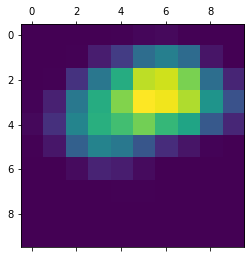

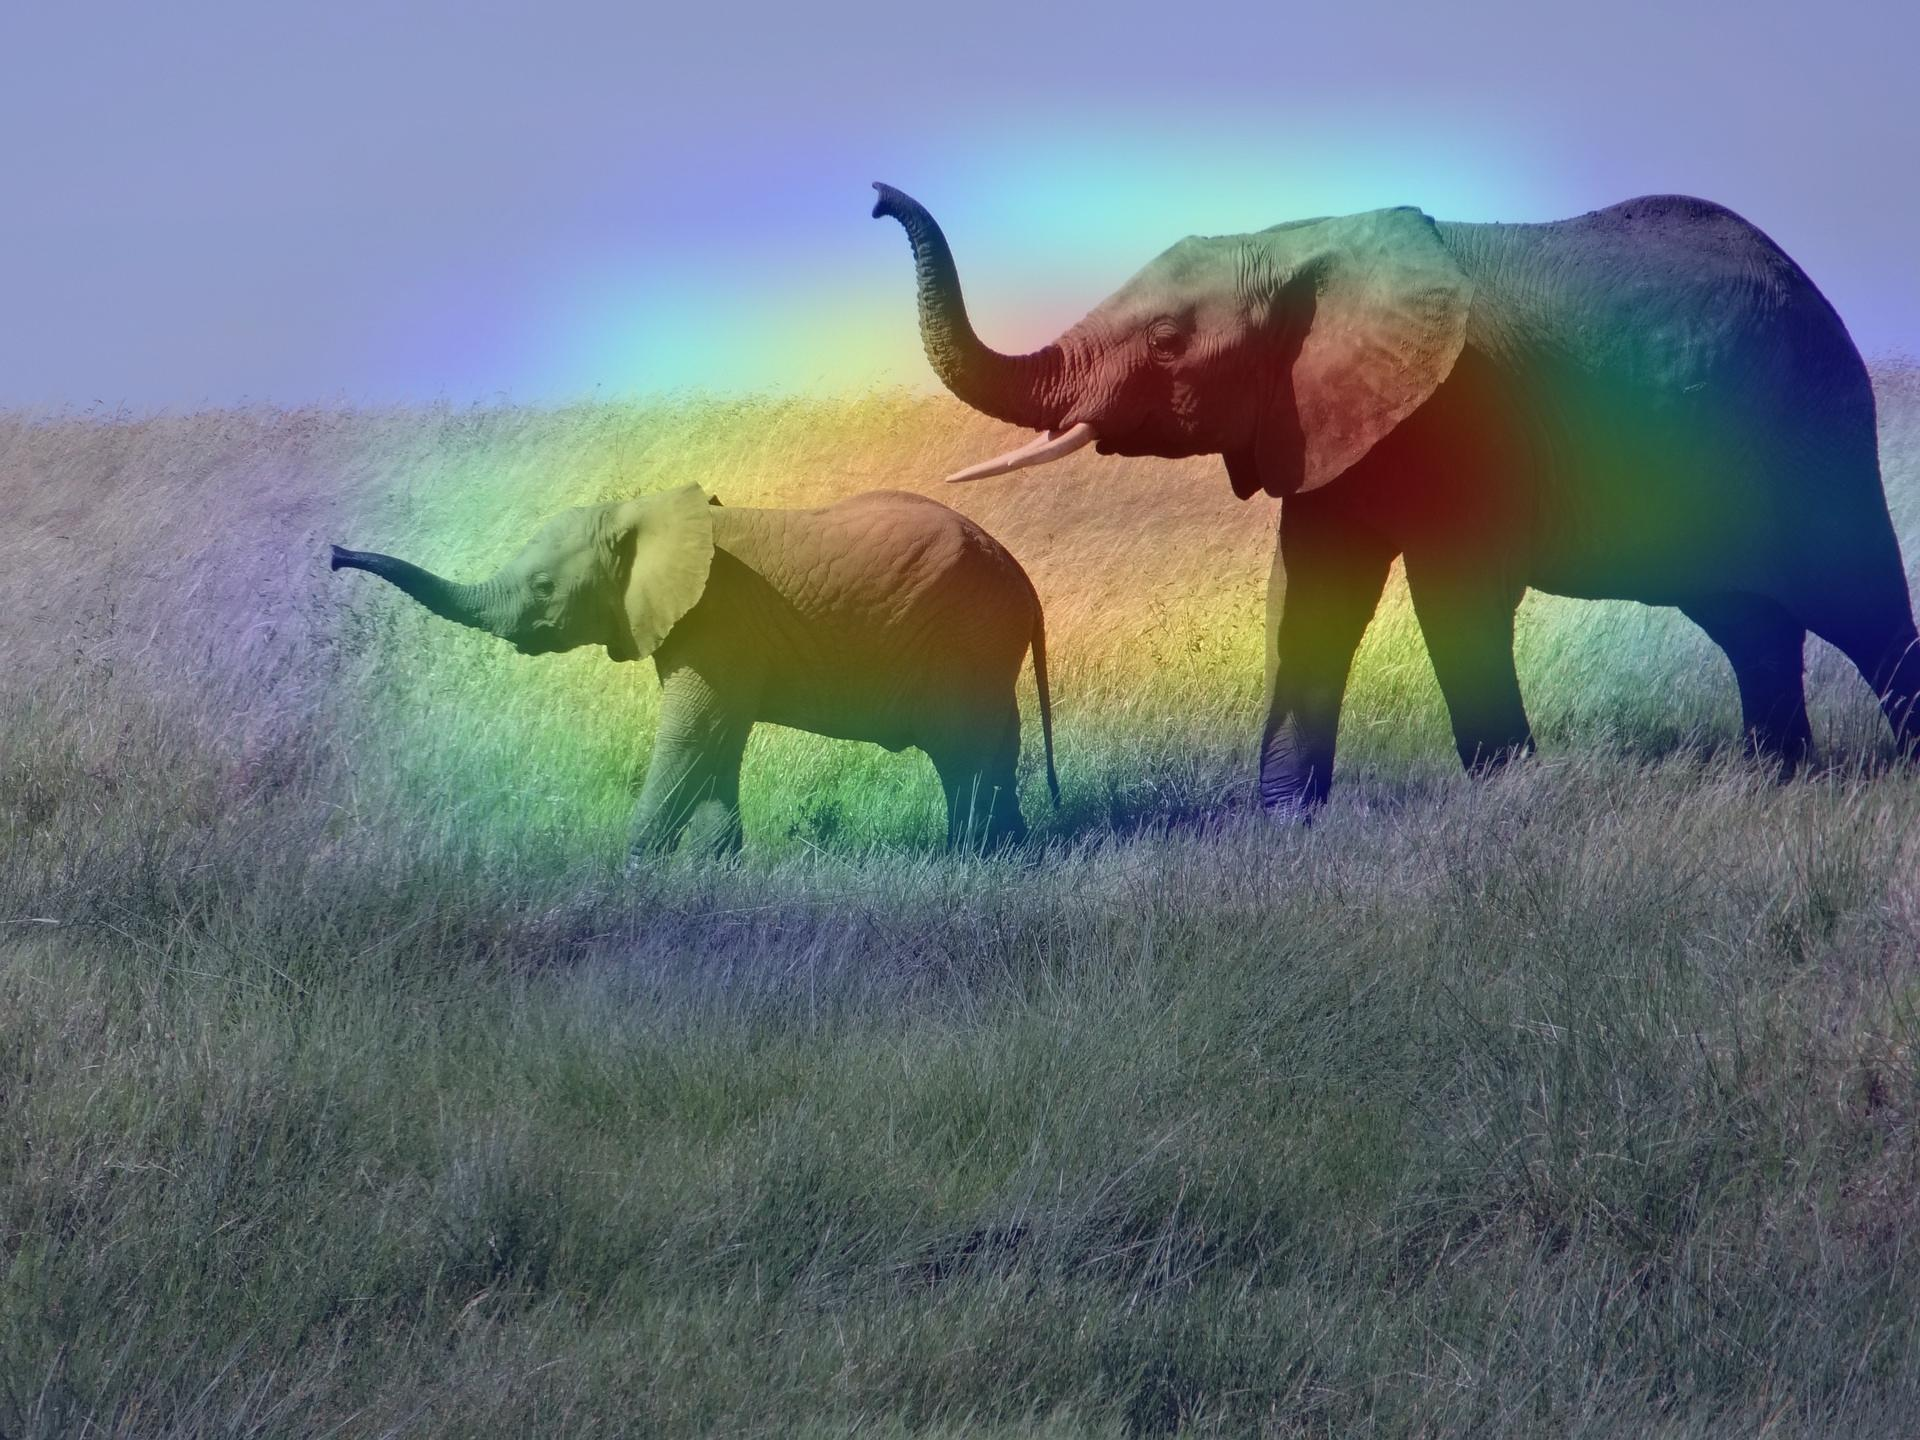

In [ ]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))


save_and_display_gradcam(img_path, heatmap)

In [ ]:
print(img_array.shape, heatmap.shape)

(1, 299, 299, 3) (10, 10)


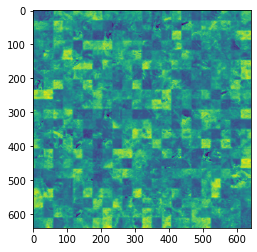

In [ ]:
dataset = gdal.Open(r'/home/priyanshu/2014_predOverlay.tif')
band1 = dataset.GetRasterBand(1)
b1 = band1.ReadAsArray()

img = np.dstack((b1)).squeeze()
f = plt.figure()
plt.imshow(img)
# plt.savefig('Tiff.png')
plt.show()

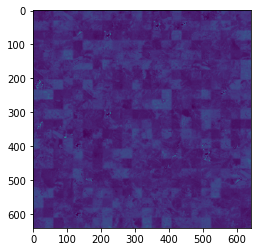

In [ ]:
dataset = gdal.Open(r'/home/priyanshu/2014_testOverlay.tif')
band1 = dataset.GetRasterBand(1)
b1 = band1.ReadAsArray()

img = np.dstack((b1)).squeeze()
f = plt.figure()
plt.imshow(img)
# plt.savefig('Tiff.png')
plt.show()

In [ ]:
!pwd

/home/akshat
